# Celestial mechanics with the `celmech` code

**Sam Hadden** (CITA)

Collaborators: **Dan Tamayo** (Princeton), **David Hernandez** (CfA)


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sympy import init_printing
init_printing()

# What is `celmech`?

- Code for celestial mechanics calculations
    - Calculate disturbing function expansion
    - Construct, manipulate, and integrate Hamiltonian equations of motion
    - Much more...
- Developed mainly in `python`
- Designed to work with the [`rebound`](https://github.com/hannorein/rebound) N-body code (Rein & Liu 2012)
- Symbolic mathematics with [`sympy`](https://www.sympy.org/en/index.html) (Meurer et. al. 2017)

# Where is `celmech`?

- PyPI: ``pip install celmech``
- GitHub reposity at [github.com/shadden/celmech](https://github.com/shadden/celmech) 
    - Includes lots of Jupyter notebook examples
- Documentation at [celmech.readthedocs.io](https://celmech.readthedocs.io)
- This notebook is available on [GitHub](https://github.com/shadden/CelmechTutorial_SaoPauloState_Aug2022)!

# Basic principles
 - $N$-body codes like `rebound` integrate equations of motion directly:
    $$
    \dot{\mathbf{r}}_i = \frac{1}{m_i}\mathbf{p_i}\\
    \dot{\mathbf{p}}_i = -\sum_{i\ne j}Gm_im_j\frac{(\mathbf{r}_i - \mathbf{r}_j)}{|\mathbf{r}_i - \mathbf{r}_j|^3}
    $$


# Basic principles
- `celmech` works with approximate equations of motion.
    - Derived from disturbing function expansion of Hamiltonian in powers of $e$ and $s = \sin(I/2)$:
 $$
 \begin{multline}
 -\frac{Gm_im_j}{|\mathbf{r}_i - \mathbf{r}_j |} +\mathrm{indirect~terms^*}
 =\\ 
 -\frac{Gm_im_j}{a_j}
      \sum_{\bf k}     
     \sum_{\nu_1,\nu_2,\nu_3,\nu_4=0}^\infty                       
     \tilde{C}_{\bf k}^{{\nu}}(\alpha)
     s_i^{|k_5|+2\nu_1}
     s_j^{|k_6|+2\nu_2}
     e_i^{|k_3|+2\nu_3}
     e_i^{|k_4|+2\nu_4}
     \\
     \times \cos(k_1\lambda_j+k_2\lambda_i+k_3\varpi_i+k_4\varpi_j+k_5\Omega_i+k_6\Omega_j)
 \end{multline}
$$


- Equations formulated in canonical "action-angle" variables
- Allows theoretical insights and potentially faster integration

'*': coodinate-system dependent

# An example
A system of two Earth-mass planets near a 3:2 mean motion resonance

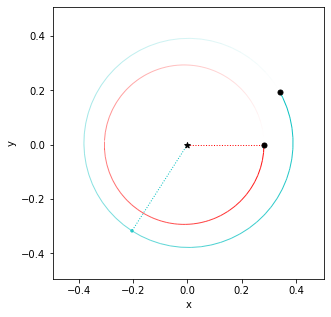

In [2]:
import rebound
rebound_sim = rebound.Simulation()
rebound_sim.add(m=1)
rebound_sim.add(m=3e-6,P = 1, e = 0.04)
rebound_sim.add(m=3e-6,P = 3 / 2, e = 0.02,l=0.5,pomega = np.pi+1)

rebound.OrbitPlot(rebound_sim,color=True,periastron=True);

In [3]:
#make an extra copy of our simulation for higher-order model later
sim2=rebound_sim.copy()

# Initializing a ``celmech`` model 
- Create `Poincare` and `PoincareHamiltonian` instances
- Initialize directly from a ``rebound`` simulation

In [4]:
from celmech import Poincare, PoincareHamiltonian
poincare_particles = Poincare.from_Simulation(rebound_sim)
Hp = PoincareHamiltonian(poincare_particles)

# The ``Poincare`` class 
- Represents system in terms of canonical variable pairs:
 $$\begin{align}
 \Lambda_i&= \mu_i\sqrt{GM_ia_i} ~;~ \lambda_i \\
 (\eta_i,\kappa_i)&\approx \sqrt{\Lambda_i}e_i \times(-\sin\varpi_i,\cos\varpi_i)\\
  (\rho_i,\sigma_i)&\approx \sqrt{\Lambda_i}\sin(I_i/2) \times(-\sin\Omega_i,\cos\Omega_i)\\
 \end{align}$$

In [5]:
type(poincare_particles)

celmech.poincare.Poincare

In [6]:
qp_pairs = poincare_particles.qp_pairs
qp_pairs

[(λ₁, Λ₁), (η₁, κ₁), (ρ₁, σ₁), (λ₂, Λ₂), (η₂, κ₂), (ρ₂, σ₂)]

# The ``Poincare`` class 
- Stores numerical values of canonical variables

In [7]:
Lambda1 = qp_pairs[0][1]
Lambda1, poincare_particles.qp[Lambda1]

(Λ₁, 1.625772780575234e-06)

- Also provides orbital mass, orbital elements, etc.

In [8]:
G = poincare_particles.G
particle = poincare_particles.particles[1]
particle.mu * np.sqrt(G * particle.M * particle.a)

1.625772780575234e-06

# The ``PoincareHamiltonian`` class 
- Represents a planetary system's Hamiltonian


In [9]:
type(Hp)

celmech.poincare.PoincareHamiltonian

- The ``H`` attribute stores the symbolic Hamiltonian
    - Keplerian terms upon intialization 

In [10]:
Hp.H

   2   2   3    2   2   3
  G ⋅M₂ ⋅μ₂    G ⋅M₁ ⋅μ₁ 
- ────────── - ──────────
        2            2   
    2⋅Λ₂         2⋅Λ₁    

 - Or, in orbital elements: 
 $$
 -\frac{Gm_*m_1}{2a_1}-\frac{Gm_*m_2}{2a_2}
 $$

# The ``PoincareHamiltonian`` class 
- Stores numerical values of symbolic parameters as well

In [11]:
Hp.N_H

  1.34999595001215e-17   1.34999595001215e-17
- ──────────────────── - ────────────────────
            2                      2         
          Λ₂                     Λ₁          

# Building a Hamiltonian
- Users build up a Hamiltonian by selecting and adding disturbing function terms
- ``PoincareHamiltonian`` includes an extensive interface for specifying and adding terms
- We'll add terms for the 3:2 MMR

In [12]:
Hp.add_MMR_terms(p=3,q=1,max_order=1,indexIn=1,indexOut=2)

- The symbolic Hamiltonian is updated with the newly-added terms

In [13]:
Hp.H

                                                               ⎛η₁⋅sin(2⋅λ₁ - 3⋅λ₂)   κ₁⋅cos(2⋅λ₁ - 3⋅λ₂)⎞                                
  C_{(3,-2,-1,0,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅⎜─────────────────── + ───────────────────⎟   C_{(3,-2,0,-1,0,0)}_{1,2})__{
                                                               ⎜   _______________       _______________ ⎟                                
                                                               ⎝ ╲╱ \Lambda_{1,0}      ╲╱ \Lambda_{1,0}  ⎠                                
- ──────────────────────────────────────────────────────────────────────────────────────────────────────── - ─────────────────────────────
                                                  a_{2,0}                                                                                 
                                                                                                                                          

                          

# Building a Hamiltonian
- Equivalent in terms of orbital elements:

In [14]:
Hp.df

<IPython.core.display.Math object>

# Integrating Hamilton's equations
 - Equations of motion automatically generated from the Hamiltonian
 - Integration and particle interface designed to mirror ``rebound``

In [15]:
rebound_particles = rebound_sim.particles
celmech_particles = Hp.particles

# times to save output
times = np.linspace(0,500 * rebound_particles[1].P,100)

# Arrays to store results
eIn_rebound,eIn_celmech = np.zeros((2,100))

# Main integration loop
for i,t in enumerate(times):
    rebound_sim.integrate(t)
    Hp.integrate(t)
    # save eccentricity of inner planet
    eIn_rebound[i] = rebound_particles[1].e
    eIn_celmech[i] = celmech_particles[1].e
    

# Comparing $N$-body and ``celmech``
- The simple ``celmech`` model shows fair agreement with direct $N$-body integration

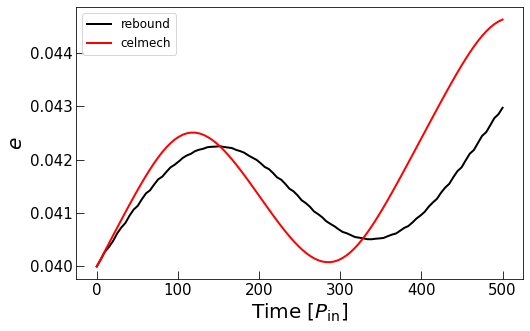

In [16]:
fig,ax = plt.subplots(1,sharex=True,figsize=(8,5))
plt.tick_params(labelsize=15,direction='in',size=8)
ax.plot(times,eIn_rebound,color='k',lw=2,label='rebound')
ax.plot(times,eIn_celmech,color='r',lw=2,label='celmech')
ax.set_ylabel(r"$e$",fontsize=20)
ax.legend(fontsize=12)
ax.set_xlabel(r"Time [$P_\mathrm{in}$]",fontsize=20);

# Making a more accurate ``celmech`` model
Now we'll include:
- Secular terms up to 2nd order in planets' eccentricities
- 3:2 resonant terms up to 3rd order in planets' eccentricities

In [17]:
pvars = Poincare.from_Simulation(sim2)
Hp = PoincareHamiltonian(pvars)

In [18]:
Hp.add_secular_terms(max_order=2,indexIn=1,indexOut=2,inclinations=False)
Hp.add_MMR_terms(p=3,q=1,max_order=3,indexIn=1,indexOut=2,inclinations=False)

# Terms included in the improved model
Many more disturbing function terms are now included:

- Secular terms:
$$
\tilde{C}_{(0,0,0,0,0,0)}^{(0,0,0,1)}(\alpha_{1,2})e_2^2
+\tilde{C}_{(0,0,0,0,0,0)}^{(0,0,1,0)}(\alpha_{1,2})e_1^2
+\tilde{C}_{(0,0,-1,1,0,0)}^{(0,0,0,0)}(\alpha_{1,2})e_1e_2\cos(-\varpi_1+\varpi_2)
$$

# ...

- 6:4 terms:
$$
\tilde{C}_{(6,-4,0,-2,0,0)}^{(0,0,0,0)}(\alpha_{1,2})e_2^2\cos(6\lambda_2-4\lambda_1-2\varpi_2)\\
+\tilde{C}_{(6,-4,-1,-1,0,0)}^{(0,0,0,0)}(\alpha_{1,2})e_1e_2\cos(6\lambda_2-4\lambda_1-\varpi_1-\varpi_2)\\
+\tilde{C}_{(6,-4,-2,0,0,0)}^{(0,0,0,0)}(\alpha_{1,2})e_1^2\cos(6\lambda_2-4\lambda_1-2\varpi_1)
$$

# ...
- 9:6 terms:
$$
\tilde{C}_{(9,-6,0,-3,0,0)}^{(0,0,0,0)}(\alpha_{1,2})e_2^3\cos(9\lambda_2-6\lambda_1-3\varpi_2)\\
+
\tilde{C}_{(9,-6,-1,-2,0,0)}^{(0,0,0,0)}(\alpha_{1,2})e_1e_2^2\cos(9\lambda_2-6\lambda_1-\varpi_1-2\varpi_2)
\\
+
\tilde{C}_{(9,-6,-2,-1,0,0)}^{(0,0,0,0)}(\alpha_{1,2})e_1^2e_2\cos(9\lambda_2-6\lambda_1-2\varpi_1-\varpi_2)\\
+\tilde{C}_{(9,-6,-3,0,0,0)}^{(0,0,0,0)}(\alpha_{1,2})e_1^3\cos(9\lambda_2-6\lambda_1-3\varpi_1)
$$

# ...
- 3rd order 3:2 terms:
$$
\left(\tilde{C}_{(3,-2,0,-1,0,0)}^{(0,0,0,1)}(\alpha_{1,2})e_2^3 + 
\tilde{C}_{(3,-2,0,-1,0,0)}^{(0,0,1,0)}(\alpha_{1,2})e_1^2e_2\right)\cos(3\lambda_2-2\lambda_1-\varpi_2)\\
+\left(\tilde{C}_{(3,-2,-1,0,0,0)}^{(0,0,0,1)}(\alpha_{1,2})e_1e_2^2
+\tilde{C}_{(3,-2,-1,0,0,0)}^{(0,0,1,0)}(\alpha_{1,2})e_1^3\right)\cos(3\lambda_2-2\lambda_1-\varpi_1)\\
+
\tilde{C}_{(3,-2,1,-2,0,0)}^{(0,0,0,0)}(\alpha_{1,2})e_1e_2^2\cos(3\lambda_2-2\lambda_1+\varpi_1-2\varpi_2)\\
+\tilde{C}_{(3,-2,-2,1,0,0)}^{(0,0,0,0)}(\alpha_{1,2})e_1^2e_2\cos(3\lambda_2-2\lambda_1-2\varpi_1+\varpi_2)
$$

These terms would be tedious to add by hand...

In [19]:
from celmech.lie_transformations import FirstOrderGeneratingFunction
chi = FirstOrderGeneratingFunction(pvars)
chi.add_zeroth_order_term(indexIn=1,indexOut=2)
chi.add_MMR_terms(2,1,indexIn=1,indexOut=2)
chi.add_MMR_terms(4,1,indexIn=1,indexOut=2)
chi.osculating_to_mean()

In [20]:
rebound_particles = sim2.particles
celmech_particles = Hp.particles
times = np.linspace(0,500 * rebound_particles[1].P,100)
eIn_rebound,eIn_celmech = np.zeros((2,100))
thetaIn_rebound,thetaIn_celmech = np.zeros((2,100))
energy = np.zeros(100)
for i,t in enumerate(times):
    sim2.integrate(t)
    Hp.integrate(t)
    energy[i] = Hp.calculate_energy()
    eIn_rebound[i] = rebound_particles[1].e
    eIn_celmech[i] = celmech_particles[1].e
    
    thetaIn_rebound[i] = -2*rebound_particles[1].l + 3*rebound_particles[2].l - rebound_particles[1].pomega
    thetaIn_celmech[i] = -2*celmech_particles[1].l + 3*celmech_particles[2].l - celmech_particles[1].pomega

# Improved agreement with higher order model
The higher-order model now shows excellent agreement with $N$-body

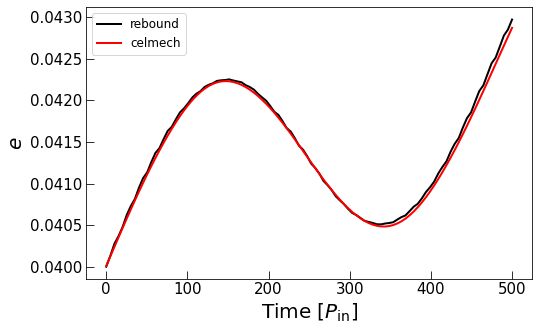

In [21]:
fig,ax = plt.subplots(1,sharex=True,figsize=(8,5))
plt.tick_params(labelsize=15,direction='in',size=8)
ax.plot(times,eIn_rebound,color='k',lw=2,label='rebound')
ax.plot(times,eIn_celmech,color='r',lw=2,label='celmech')
ax.set_ylabel(r"$e$",fontsize=20)
ax.legend(fontsize=12)
ax.set_xlabel(r"Time [$P_\mathrm{in}$]",fontsize=20);

# A simpler model via canonical transformations
- Present ``celmech`` equations involve 12 variables:

In [22]:
Hp.qp_vars

[λ₁, η₁, ρ₁, λ₂, η₂, ρ₂, Λ₁, κ₁, σ₁, Λ₂, κ₂, σ₂]

# A simpler model via canonical transformations
$$\newcommand{pd}[2]{\frac{\partial #1}{\partial #2}}$$
- Seek canonical transformation, 
     $$T : (q_i,p_i)\rightarrow (\phi_1,...,\phi_M,Q_1,Q_{N-M},I_1,...,I_M,P_1,...,P_{N-M})$$
   such that the new Hamiltonian, $H' = H \circ T^{-1}$ does not depend explicitly on the new coordinates, $\phi_i$.
- Hamilton's equations give $$\dot{I_i}=\pd{}{\phi_i}H'=0$$ so that the variables $I_i$ are conserved.
- Can consider equations with $N-M$ degrees of freedom: $$\begin{align}
\dot{Q_i} &= \pd{}{P_i}H'(Q,P;I)\\
\dot{P_i} &= -\pd{}{Q_i}H'(Q,P;I)\\
\end{align}$$ 

# A simpler model via canonical transformations
 - Present Hamiltonian depends on angle variables only via the combinations
 $$Q_i = 3\lambda_2 - 2\lambda_1 + \gamma_i$$
 - We'll use ``celmech`` to transform to new variables
 $$
 \begin{pmatrix}
 Q_1\\
 Q_2\\
 \phi_1\\
 \phi_2
 \end{pmatrix} = 
 \begin{pmatrix}
 -2 & 3 & 1 & 0 \\
 -2 & 3 & 0 & 1 \\
 -2 & 3 & 0 & 0 \\
 1 & -1 & 0 & 0
 \end{pmatrix}\cdot
  \begin{pmatrix}
 \lambda_1\\
 \lambda_2\\
 \gamma_1 \\
 \gamma_2
 \end{pmatrix}
 $$

# A simpler model via canonical transformations
 - Implement transformation with the `CanonicalTransformation` class

In [23]:
from celmech import CanonicalTransformation
from sympy import symbols
T = np.eye(Hp.N_dof,dtype=int)
T[0,:4] = [-2,3,1,0]
T[1,:4] = [-2,3,0,1]
T[2,:4] = [-2,3,0,0]
T[3,:4] = [1,-1,0,0]

# Symbols to use for new variables
new_qs = symbols("Q(1:3),phi(1:5)")
new_ps = symbols("P(1:3),I(1:5)")
new_qp_pairs = list(zip(new_qs,new_ps))

ct = CanonicalTransformation.from_poincare_angles_matrix(Hp.state,T,new_qp_pairs=new_qp_pairs)
type(ct)

celmech.canonical_transformations.CanonicalTransformation

# A simpler model via canonical transformations
 - `new_to_old` transforms expressions in terms of new variables to expressions in terms of old variables

In [24]:
for q in new_qs:
    display((q,ct.new_to_old(q)))

(Q₁, -2⋅λ₁ + 3⋅λ₂ + atan2(η₁, κ₁))

(Q₂, -2⋅λ₁ + 3⋅λ₂ + atan2(η₂, κ₂))

(φ₁, -2⋅λ₁ + 3⋅λ₂)

(φ₂, λ₁ - λ₂)

(φ₃, atan2(ρ₁, σ₁))

(φ₄, atan2(ρ₂, σ₂))

# A simpler model via canonical transformations
 - The `old_to_new_hamiltonian` method produces a new Hamiltonian object

In [25]:
ham_transformed = ct.old_to_new_hamiltonian(Hp,do_reduction=True)
type(ham_transformed)

celmech.hamiltonian.Hamiltonian

# A simpler model via canonical transformations
 - The new Hamiltonian is expressed in terms of the new variables

In [28]:
display(ham_transformed.H)

                                                            ____   ____                                                                   
  2⋅C_{(0,0,-1,1,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅╲╱ P₁ ⋅╲╱ P₂ ⋅m₁⋅m₂⋅cos(Q₁ - Q₂)   2⋅C_{(0,0,0,0,0,0)}_{1,2})__{(0,0,0,1),(0,0)}
- ──────────────────────────────────────────────────────────────────────────────────────── - ─────────────────────────────────────────────
                          _______________   _______________                                                       \Lambda_{2,0}⋅a_{2,0}   
                        ╲╱ \Lambda_{1,0} ⋅╲╱ \Lambda_{2,0} ⋅a_{2,0}                                                                       

                                                                                                                                          
(\alpha⋅G⋅P₂⋅m₁⋅m₂   2⋅C_{(0,0,0,0,0,0)}_{1,2})__{(0,0,1,0),(0,0)}(\alpha⋅G⋅P₁⋅m₁⋅m₂   √2⋅C_{(3,-2,-1,0,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\a
────────────────── - ─────

# A simpler model via canonical transformations
 - The number of degrees of freedom have been reduced
 - Conserved quantities are now parameters of the Hamiltonian 

In [27]:
conserved_quantities = []
full_Ps = ham_transformed.full_qp_vars[ham_transformed.full_N_dof:]
for P in full_Ps:
    if P not in ham_transformed.qp_vars:
        qty = ct.new_to_old(P)
        conserved_quantities.append(qty)
        display((P,qty))

⎛                2     2     2     2⎞
⎜              η₁    η₂    κ₁    κ₂ ⎟
⎜I₁, Λ₁ + Λ₂ - ─── - ─── - ─── - ───⎟
⎝               2     2     2     2 ⎠

(I₂, 3⋅Λ₁ + 2⋅Λ₂)

⎛      2     2⎞
⎜    ρ₁    σ₁ ⎟
⎜I₃, ─── + ───⎟
⎝     2     2 ⎠

⎛      2     2⎞
⎜    ρ₂    σ₂ ⎟
⎜I₄, ─── + ───⎟
⎝     2     2 ⎠


# Application: Determine resonant equilibrium configuration
- Search for configuration such, $\frac{d}{dt}{Q_i}=0$ and $\frac{d}{dt}I_i =0$
- Transform back to original variables using `celmech`'s canonical transformations.
- Produce `rebound` simulation at resonant equilibrium.


# Application: Determine resonant equilibrium configuration
 - Apply additional canonical transformation $$(P_i,Q_i) \rightarrow (x_i,y_i):=\sqrt{2P_i}(\sin Q_i,\cos Q_i)$$
 - Numerically easier to find root $\frac{d}{dt}(y_1,y_2,x_1,x_2)=0$

In [30]:
polar_to_cart = CanonicalTransformation.polar_to_cartesian(ham_transformed.full_qp_vars,[0,1])
ham_xy = polar_to_cart.old_to_new_hamiltonian(ham_transformed)

# Application: Resonant equilibrium configuration
 - The function `ham_xy.flow_func` gives $$\mathbf{F}(y_1,y_2,x_1,x_2) = \begin{pmatrix} \pd{H'}{x_1}\\ \pd{H'}{x_2} \\ -\pd{H'}{y_1}\\ -\pd{H'}{y_2} \end{pmatrix}$$
 - The function `ham_xy.jacobian_func` gives the Jacobian matrix $\nabla\mathbf{F}$
 - Use `scipy.optimize.root` to find $(y^*_1,y^*_2,x^*_1,x^*_2)$  such that $\mathbf{F}(y^*_1,y^*_2,x^*_1,x^*_2)=0$

In [48]:
from scipy.optimize import root
f = lambda v: ham_xy.flow_func(*v).reshape(-1)
Df = lambda v: ham_xy.jacobian_func(*v)
root_soln = root(f,np.zeros(4),jac = Df)
yx_star = root_soln.x

# Application: Resonant equilibrium configuration
 - Set state of `ham_xy` to equilibrium values

In [50]:
# Confirm equlibrium condition
ham_xy.state.values = yx_star
print(ham_xy.calculate_flow())

[ 8.53650392e-22 -1.62789145e-21  2.20772355e-36  2.66228640e-35]


# Application: Resonant equilibrium configuration
- Create canonical transformation given by composition of previous transformations

In [52]:
ct_composite = CanonicalTransformation.composite([ct, polar_to_cart])
print("Old variables:")
display(ct_composite.old_qp_vars)
print("New variables:")
display(ct_composite.new_qp_vars)

Old variables:


[λ₁, η₁, ρ₁, λ₂, η₂, ρ₂, Λ₁, κ₁, σ₁, Λ₂, κ₂, σ₂]

New variables:


[y₁, y₂, φ₁, φ₂, φ₃, φ₄, x₁, x₂, I₁, I₂, I₃, I₄]

# Application: Resonant equilibrium configuration
- Apply inverse transformation to new variable values

In [53]:
new_var_values = ham_xy.full_values
old_var_values = ct_composite.new_to_old_array(new_var_values)